In [5]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import random
import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [6]:
file = "/kaggle/input/data-images/train_labels.csv"
df = pd.read_csv(file)
df["image_name"] = df["filename"].apply(lambda link: os.path.basename(link))
df

,filename,width,height,class,xmin,ymin,xmax,ymax,image_name
0,Data-Images/Cars/105.jpg,684,293,license_plate,12,106,696,399,105.jpg
1,Data-Images/Cars/38.jpg,118,39,license_plate,794,485,912,524,38.jpg
2,Data-Images/Cars/136.jpg,173,74,license_plate,155,200,328,274,136.jpg
3,Data-Images/Cars/127.jpg,416,154,license_plate,191,54,607,208,127.jpg
4,Data-Images/Cars/21.jpg,238,63,license_plate,272,2,510,65,21.jpg
...,...,...,...,...,...,...,...,...,...
220,Data-Images/Cars/106.jpg,97,61,license_plate,229,187,326,248,106.jpg
221,Data-Images/Cars/188.jpg,260,61,license_plate,787,241,1047,302,188.jpg
222,Data-Images/Cars/90.jpg,71,44,license_plate,313,103,384,147,90.jpg
223,Data-Images/Cars/165.jpg,203,67,license_plate,114,173,317,240,165.jpg


In [7]:
df = df.sort_values(by=["filename"])
df

,filename,width,height,class,xmin,ymin,xmax,ymax,image_name
18,Data-Images/Cars/0.jpg,119,47,license_plate,581,273,700,320,0.jpg
148,Data-Images/Cars/1.jpg,209,68,license_plate,79,381,288,449,1.jpg
70,Data-Images/Cars/10.jpg,222,81,license_plate,199,138,421,219,10.jpg
201,Data-Images/Cars/100.jpg,199,109,license_plate,28,52,227,161,100.jpg
142,Data-Images/Cars/101.jpg,206,98,license_plate,20,55,226,153,101.jpg
...,...,...,...,...,...,...,...,...,...
47,Data-Images/Cars/95.jpg,369,115,license_plate,301,419,670,534,95.jpg
15,Data-Images/Cars/96.jpg,281,75,license_plate,315,192,596,267,96.jpg
159,Data-Images/Cars/97.jpg,98,53,license_plate,122,116,220,169,97.jpg
122,Data-Images/Cars/98.jpg,188,84,license_plate,25,63,213,147,98.jpg


In [8]:
image_folder = "/kaggle/input/data-images/Cars/"
# Read the image dimensions and normalize the bounding box values
for index, row in df.iterrows():
    image_path = os.path.join(image_folder, row["image_name"])
    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape

    df.at[index, "xmin"] = row["xmin"] / image_width
    df.at[index, "ymin"] = row["ymin"] / image_height
    df.at[index, "xmax"] = row["xmax"] / image_width
    df.at[index, "ymax"] = row["ymax"] / image_height


In [9]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,image_name
18,Data-Images/Cars/0.jpg,119,47,license_plate,0.720844,0.585837,0.868486,0.686695,0.jpg
148,Data-Images/Cars/1.jpg,209,68,license_plate,0.159919,0.848552,0.582996,1.000000,1.jpg
70,Data-Images/Cars/10.jpg,222,81,license_plate,0.309969,0.345000,0.655763,0.547500,10.jpg
201,Data-Images/Cars/100.jpg,199,109,license_plate,0.112903,0.293785,0.915323,0.909605,100.jpg
142,Data-Images/Cars/101.jpg,206,98,license_plate,0.080645,0.310734,0.911290,0.864407,101.jpg


In [10]:
WIDTH = 299
HEIGHT = 299
CHANNEL = 3

def show_img(index):
    image = cv2.imread("/kaggle/input/data-images/Cars/" + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    normalized_bbox_x = df["xmin"].iloc[index]
    normalized_bbox_y = df["ymin"].iloc[index]
    normalized_bbox_width = df["xmax"].iloc[index]
    normalized_bbox_height = df["ymax"].iloc[index]

    # Convert normalized bounding box values to pixel coordinates
    tx = int(normalized_bbox_x * WIDTH)
    ty = int(normalized_bbox_y * HEIGHT)
    bx = int((normalized_bbox_x + normalized_bbox_width) * WIDTH)
    by = int((normalized_bbox_y + normalized_bbox_height) * HEIGHT)

    # Draw the bounding box on the image
    image_with_bbox = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 2)

    plt.imshow(image_with_bbox)
    plt.show()


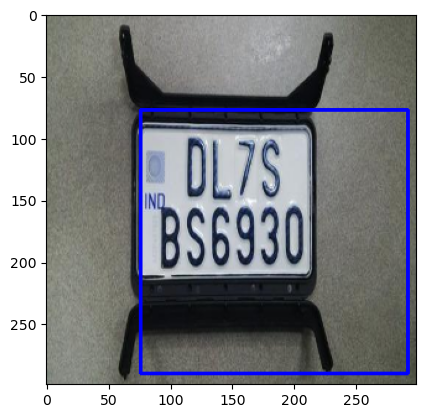

In [11]:
show_img(5)

In [12]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    df,
    directory="/kaggle/input/data-images/Cars",
    x_col="image_name",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(WIDTH, HEIGHT),
    batch_size=16, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    df,
    directory="/kaggle/input/data-images/Cars",
    x_col="image_name",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(WIDTH, HEIGHT),
    batch_size=16, 
    class_mode="other",
    subset="validation")

Found 203 validated image filenames.
Found 22 validated image filenames.


In [13]:
from tensorflow.keras.applications import InceptionResNetV2
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(299,299,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dropout(0.25)(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)

# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [14]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
#model.summary()

In [15]:
tfb = TensorBoard('object_detection')
history = model.fit(train_generator,batch_size=16,epochs=50,
                    validation_data=validation_generator,callbacks=[tfb])

Epoch 1/50
13/13 [==============================] - 117s 917ms/step - loss: 0.1208 - val_loss: 0.1018
Epoch 2/50
13/13 [==============================] - 5s 354ms/step - loss: 0.1174 - val_loss: 0.0808
Epoch 3/50
13/13 [==============================] - 5s 357ms/step - loss: 0.1114 - val_loss: 0.0675
Epoch 4/50
13/13 [==============================] - 5s 353ms/step - loss: 0.0990 - val_loss: 0.0533
Epoch 5/50
13/13 [==============================] - 5s 356ms/step - loss: 0.0824 - val_loss: 0.0587
Epoch 6/50
13/13 [==============================] - 5s 353ms/step - loss: 0.0637 - val_loss: 0.0443
Epoch 7/50
13/13 [==============================] - 5s 360ms/step - loss: 0.0403 - val_loss: 0.0351
Epoch 8/50
13/13 [==============================] - 5s 353ms/step - loss: 0.0253 - val_loss: 0.0369
Epoch 9/50
13/13 [==============================] - 5s 352ms/step - loss: 0.0207 - val_loss: 0.0341
Epoch 10/50
13/13 [==============================] - 5s 361ms/step - loss: 0.0194 - val_loss: 0.02

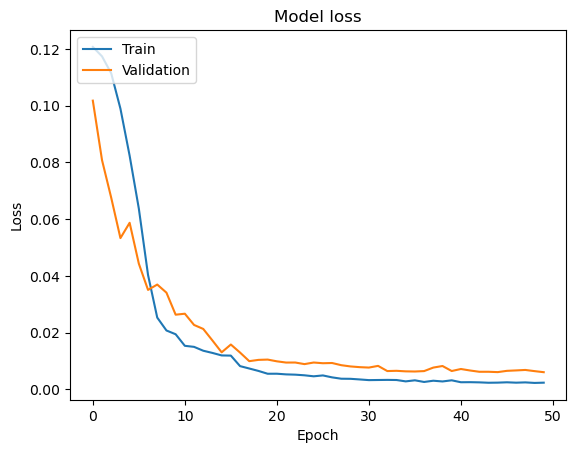

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
model.evaluate_generator(validation_generator)

0.0060318466275930405

1/1 [==============================] - 4s 4s/step


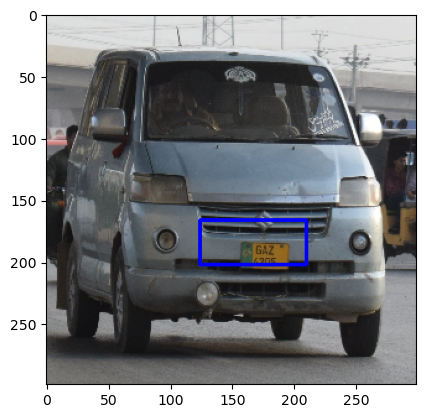

1/1 [==============================] - 0s 39ms/step


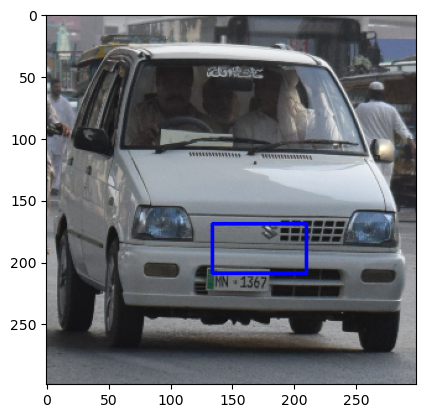

1/1 [==============================] - 0s 38ms/step


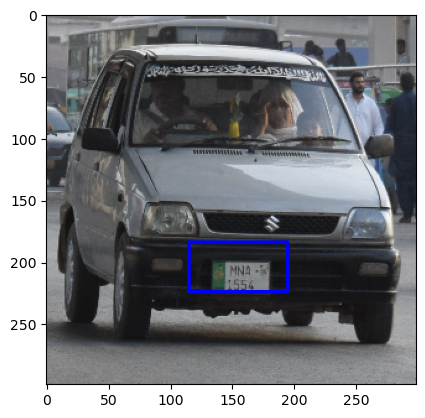

1/1 [==============================] - 0s 38ms/step


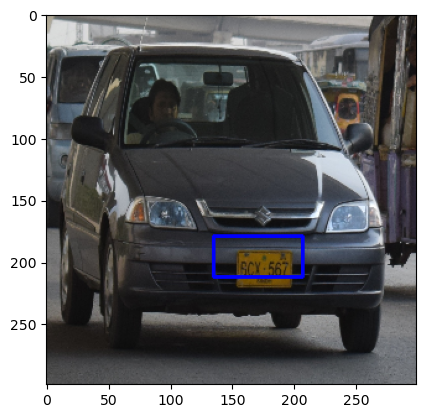

In [18]:
images_folder = "/kaggle/input/bbdataplate/Dataset_Number/Test"
image_files = os.listdir(images_folder)

for image_file in image_files:
    img_path = os.path.join(images_folder, image_file)
    img = cv2.resize(cv2.imread(img_path) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH

    xt, yt = int(y_hat[0]), int(y_hat[1])
    xb, yb = int(y_hat[2]), int(y_hat[3])

    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 2)
    plt.imshow(image)
    plt.show()


1/1 [==============================] - 0s 37ms/step


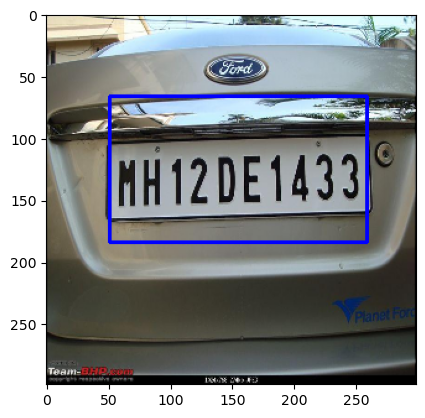

In [60]:
images_folder = "/kaggle/input/testimg11"
image_file = "d1.JPG"

img_path = os.path.join(images_folder, image_file)
img = cv2.resize(cv2.imread(img_path) / 255.0, dsize=(WIDTH, HEIGHT))
y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH

xt, yt = int(y_hat[0]), int(y_hat[1])
xb, yb = int(y_hat[2]), int(y_hat[3])
roi = img[yt:yb, xt:xb]

img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 2)
plt.imshow(image)
plt.show()


In [61]:
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 15 Cropped image')
fig.show()

In [71]:
import pytesseract as pt
roi_uint8 = (roi * 255).astype(np.uint8)
text = pt.image_to_string(roi_uint8)
print(text)

a ae a
MHIZDE1433
———————

